# Build a Deep Convolutional Generative Adversarial Network with PyTorch

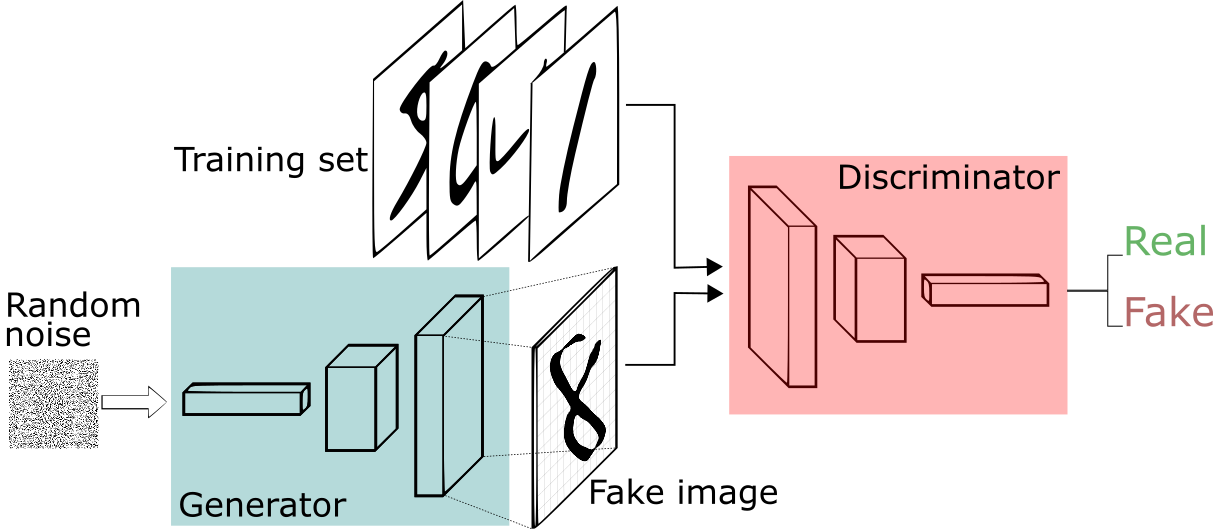

In [1]:
import torch 
torch.manual_seed(42)
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [2]:
device = 'cuda' # image = image.to(device)

batch_size = 128 # trainload, training loop

noise_dim = 64 # generator model

# Optimizers parameters
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
                        T.RandomRotation((-20, +20)),
                        T.ToTensor() # (height, width, channel) -> (channel, height, width)
])

In [7]:
train_set = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

In [8]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

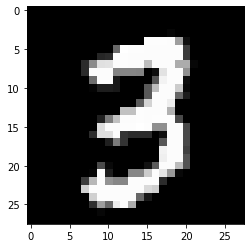

In [9]:
image, label = train_set[7]

plt.imshow(image.squeeze(), cmap='gray')

In [10]:
print(f'Total images of trainset is : {len(train_set)}')

Total images of trainset is : 60000


# Load Dataset Into Batches 

In [11]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [12]:
trainloder = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [13]:
print(f'Total of batches in trainloader : {len(trainloder)}')

Total of batches in trainloader : 469


In [14]:
data_iter = iter(trainloder)

images, _ = data_iter.next()

print(images.shape)

torch.Size([128, 1, 28, 28])


In [15]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

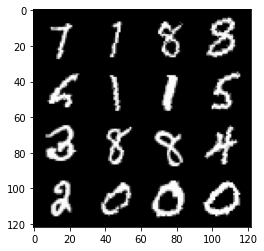

In [19]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network 


In [20]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [21]:
def get_discriminator_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, stride),
    nn.BatchNorm2d(out_channels),
    nn.LeakyReLU(0.2)
)

In [22]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1=get_discriminator_block(1,16,(3,3),2)
    self.block_2=get_discriminator_block(16,32,(5,5),2)
    self.block_3=get_discriminator_block(32,64,(5,5),2)

    self.flatten=nn.Flatten()
    self.linear=nn.Linear(64,1)

  def forward(self, images):
    x1=self.block_1(images)
    x2=self.block_2(x1)
    x3=self.block_3(x2)

    x4=self.flatten(x3)
    x5=self.linear(x4)

    return x5


In [23]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [24]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [25]:
def get_generator_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
    
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [26]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim=noise_dim
    self.block_1=get_generator_block(noise_dim, 256, (3,3), 2)
    self.block_2=get_generator_block(256,128, (4,4), 1)
    self.block_3=get_generator_block(128,64, (3,3), 2)

    self.block_4=get_generator_block(64,1,(4,4),2,final_block=True)

  def forward(self, r_noise_vec):

    # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
    x=r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1=self.block_1(x)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.block_4(x3)

    return x4

In [27]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [28]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [29]:
D=D.apply(weights_init)
G=G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [30]:
# calculate real classification loss

def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

# calculate fake classification loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [31]:
discriminator_opt = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(beta_1, beta_2)) # discriminator optimizer
generator_opt = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(beta_1, beta_2)) # generator optimizer

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 1 | Discriminator loss : 0.6949331787095141 | Generator loss : 0.5532129722109227


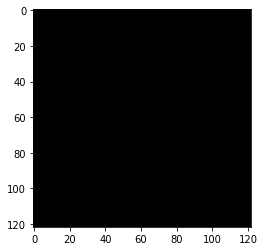

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 2 | Discriminator loss : 0.695110824570727 | Generator loss : 0.5505665141636374


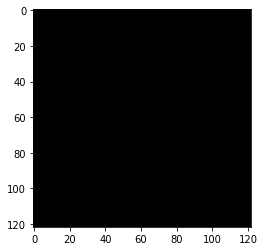

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3 | Discriminator loss : 0.6953903697192796 | Generator loss : 0.547894732657272


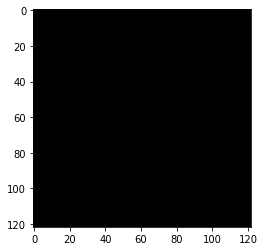

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 4 | Discriminator loss : 0.695404199521933 | Generator loss : 0.545364929033495


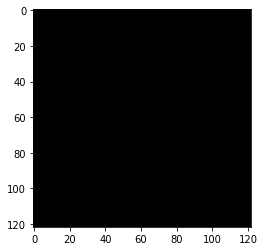

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 5 | Discriminator loss : 0.6957175757076695 | Generator loss : 0.5428564985677886


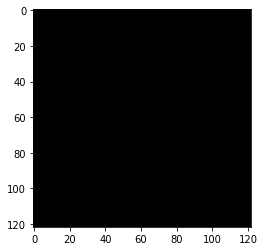

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 6 | Discriminator loss : 0.6961476211863031 | Generator loss : 0.5405542325617662


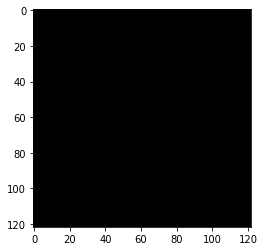

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 7 | Discriminator loss : 0.6963813670916852 | Generator loss : 0.5383909947074044


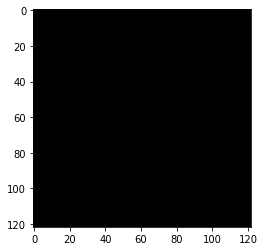

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 8 | Discriminator loss : 0.6966718707257497 | Generator loss : 0.5361107976706043


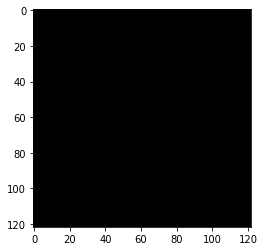

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 9 | Discriminator loss : 0.6968612200669897 | Generator loss : 0.5341292587933002


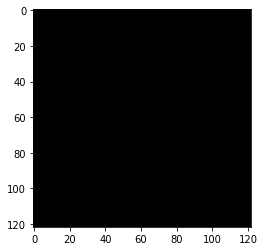

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 10 | Discriminator loss : 0.697266525042845 | Generator loss : 0.5319875005974191


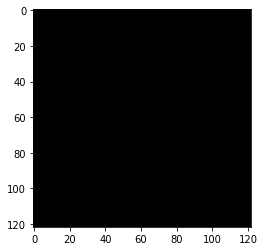

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 11 | Discriminator loss : 0.6975491415463022 | Generator loss : 0.5300812411155782


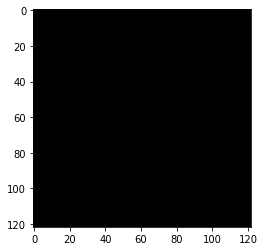

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 12 | Discriminator loss : 0.69780396690755 | Generator loss : 0.5282589813539469


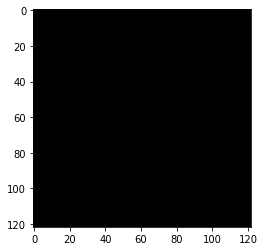

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 13 | Discriminator loss : 0.6982231082946762 | Generator loss : 0.5265280342559571


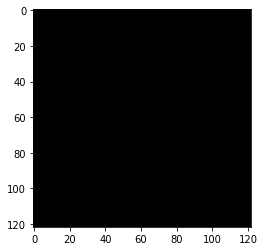

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 14 | Discriminator loss : 0.698509710429828 | Generator loss : 0.5248423006488825


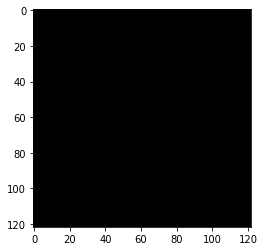

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 15 | Discriminator loss : 0.6988669613531149 | Generator loss : 0.5232196759059231


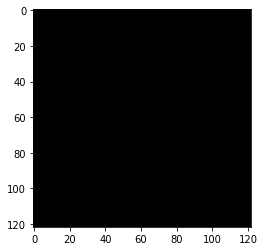

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 16 | Discriminator loss : 0.6991920061965486 | Generator loss : 0.5215052504783501


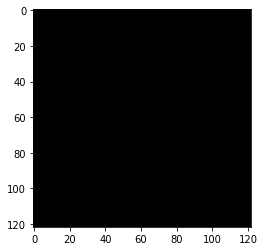

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 17 | Discriminator loss : 0.699474576185507 | Generator loss : 0.5199582053145875


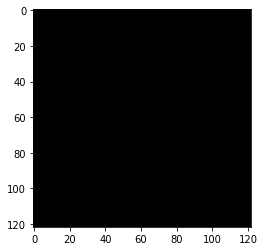

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 18 | Discriminator loss : 0.6998110244523233 | Generator loss : 0.5183482192980964


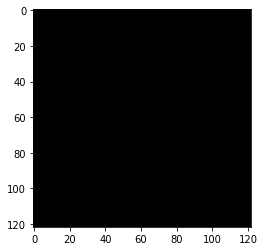

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 19 | Discriminator loss : 0.7002329761539695 | Generator loss : 0.516836168796523


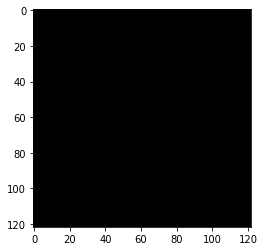

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 20 | Discriminator loss : 0.7004883258835848 | Generator loss : 0.5154176057020484


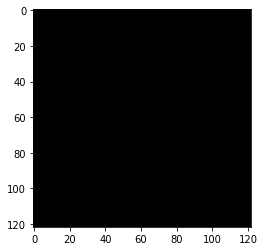

In [33]:
fake_img=0

for i in range(epochs):
  
  total_discriminator_loss=0.0
  total_generator_loss=0.0

  for real_img, _ in tqdm(trainloder):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    # find loss and update weights for discriminator

    discriminator_opt.zero_grad()

    fake_img = G(noise)
    discriminator_pred = D(fake_img)
    discriminator_fake_loss = fake_loss(discriminator_pred)

    discriminator_pred = D(real_img)
    discriminator_real_loss = real_loss(discriminator_pred)

    discriminator_loss = (discriminator_fake_loss+discriminator_real_loss)/2

    total_discriminator_loss += discriminator_loss.item()

    discriminator_loss.backward()
    discriminator_opt.step()

    # find loss and update weights for generator

    generator_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = G(noise)
    discriminator_pred = D(fake_img)
    generator_loss = real_loss(discriminator_pred)

    total_generator_loss += generator_loss.item()

    generator_loss.backward()
    generator_opt.step()

  avg_discriminator_loss = total_discriminator_loss / len(trainloder)
  avg_generator_loss = total_generator_loss / len(trainloder)

  print(f'Epoch : {i+1} | Discriminator loss : {avg_discriminator_loss} | Generator loss : {avg_generator_loss}')
  
  show_tensor_images(fake_img, num_images=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


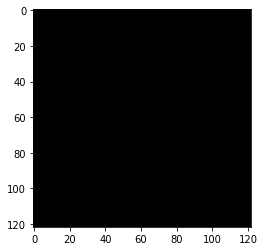

In [34]:
# Run after training is completed.
# Now we can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)